# Web Mining Project: Team 5

Team members:
* Kirill Gratchev, kirill.gratchev@students.uni-mannheim.de, 1638059
* Marc Popescu-Pfeiffer, marc.popescu-pfeiffer@students.uni-mannheim.de, 1638093 
* Lennart Fertig, lennart.fertig@students.uni-mannheim.de, 1961809
* Shiyu Li, shiyu.li@students.uni-mannheim.de, 1869814
* Andreas Edte, andreas.edte@students.uni-mannheim.de, 1920339

In [1]:
!gdown --id 1Lp9gla0BvumWFyvFfdFIIFufaKUx_gpw
!gdown --id 1458Q00M_MmMfFUg3eDGPx2CAgRTBXxbU

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Lp9gla0BvumWFyvFfdFIIFufaKUx_gpw
To: /content/steam-200k.csv
100% 8.96M/8.96M [00:00<00:00, 172MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1458Q00M_MmMfFUg3eDGPx2CAgRTBXxbU
To: /content/steam.csv
100% 5.82M/5.82M [00:00<00:00, 134MB/s]


In [2]:
!pip install surprise
!pip install xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, accuracy, SVD, KNNBaseline, NormalPredictor, SVDpp
from surprise.model_selection import train_test_split, GridSearchCV
from scipy.stats import percentileofscore
from google.colab import files

In [4]:
# Dataset CSV can be found at https://www.kaggle.com/datasets/tamber/steam-video-games
dfPlaytime = pd.read_csv('./steam-200k.csv', header=None, names=["user_id", "game_name", "action", "hours", "empty_column"]).drop(['empty_column'],axis=1)

In [5]:
# Configure Experiment
algorithms = [
    #'knn_baseline_item_based',
    'knn_baseline_user_based',
    'svd',
    'svdpp',
    'svdpp_tuned',
    'random',
]
randomSeed = 1

In [6]:
# Prepare datasets
datasets = []

# normalize by users total playtime
def normalizedByUserTotalPlaytime():
  df = dfPlaytime
  df = df.loc[df['action'] == 'play'].drop(['action'], axis=1)
  dfG = df.groupby('user_id')['hours'].sum()
  df['hours_norm'] = df.apply(lambda row: row['hours'] / dfG.loc[row['user_id']], axis=1)
  df = df.rename(columns={'hours_norm': 'Rating', 'game_name': 'Item', 'user_id': 'User'})
  df = df[['User', 'Item', 'Rating']]
  df = df.reset_index(drop=True)

  normalizedDataSet = Dataset.load_from_df(df, reader=Reader(rating_scale=(0, 1)))
  trainset, testset = train_test_split(normalizedDataSet, test_size=0.25, random_state=randomSeed)
  return {
      "train": trainset,
      "test": testset,
  }

def normalizedByGameTotalPlaytime():
  df = dfPlaytime
  df = df.loc[df['action'] == 'play'].drop(['action'], axis=1)
  dfG = df.groupby('game_name')['hours'].sum()
  df['hours_norm'] = df.apply(lambda row: row['hours'] / dfG.loc[row['game_name']], axis=1)
  df = df.rename(columns={'hours_norm': 'Rating', 'game_name': 'Item', 'user_id': 'User'})
  df = df[['User', 'Item', 'Rating']]
  df = df.reset_index(drop=True)

  normalizedDataSet = Dataset.load_from_df(df, reader=Reader(rating_scale=(0, 1)))
  trainset, testset = train_test_split(normalizedDataSet, test_size=0.25, random_state=randomSeed)
  return {
      "train": trainset,
      "test": testset,
  }

def evenlyBinnedDataSet(binCount):
    df = dfPlaytime
    df = df.loc[df['action'] == 'play'].drop(['action'], axis=1)
    df = df.sort_values(['hours'])

    userParts = np.array_split(df.sort_values(['hours'])['hours'], indices_or_sections=binCount)
    bins = [0]
    for userPart in userParts:
        bins.append(userPart.max())

    ratings = []
    for n in range(0, binCount):
        ratings.append(n/(binCount-1))
    
    print(f"Binning {binCount}")
    print(f"\t{bins}")
    print(f"\t{ratings}")

    df['hours_binned'] = pd.cut(df['hours'], bins, labels=ratings)
    df = df.rename(columns={'hours_binned': 'Rating',
                   'game_name': 'Item', 'user_id': 'User'})
    df = df.reset_index(drop=True)
    df = df[['User', 'Item', 'Rating']]

    binnedDataSet = Dataset.load_from_df(
        df, reader=Reader(rating_scale=(0, 1)))
    trainset, testset = train_test_split(
        binnedDataSet, test_size=0.25, random_state=randomSeed)
    return {
        "train": trainset,
        "test": testset,
    }

datasets.append(evenlyBinnedDataSet(3))
datasets.append(evenlyBinnedDataSet(5))
datasets.append(evenlyBinnedDataSet(10))
datasets.append(evenlyBinnedDataSet(20))
datasets.append(normalizedByUserTotalPlaytime())
datasets.append(normalizedByGameTotalPlaytime())

Binning 3
	[0, 1.7, 11.6, 11754.0]
	[0.0, 0.5, 1.0]
Binning 5
	[0, 0.7, 2.6, 7.9, 28.0, 11754.0]
	[0.0, 0.25, 0.5, 0.75, 1.0]
Binning 10
	[0, 0.3, 0.7, 1.4, 2.6, 4.5, 7.9, 14.0, 28.0, 76.0, 11754.0]
	[0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777778, 0.8888888888888888, 1.0]
Binning 20
	[0, 0.2, 0.3, 0.5, 0.7, 1.0, 1.4, 1.9, 2.6, 3.4, 4.5, 6.0, 7.9, 10.5, 14.0, 19.1, 28.0, 43.0, 76.0, 189.0, 11754.0]
	[0.0, 0.05263157894736842, 0.10526315789473684, 0.15789473684210525, 0.21052631578947367, 0.2631578947368421, 0.3157894736842105, 0.3684210526315789, 0.42105263157894735, 0.47368421052631576, 0.5263157894736842, 0.5789473684210527, 0.631578947368421, 0.6842105263157895, 0.7368421052631579, 0.7894736842105263, 0.8421052631578947, 0.8947368421052632, 0.9473684210526315, 1.0]


In [7]:
# Fit & Evaluate
results = {}

for datasetIndex, dataset in enumerate(datasets):
    for algorithmIndex, algorithm in enumerate(algorithms):
        print(f"algo={algorithm}, binning={datasetIndex}:")

        algo = None
        if algorithm == 'knn_baseline_item_based':
            algo = KNNBaseline(user_based=False, verbose=False)
        elif algorithm == 'knn_baseline_user_based':
            algo = KNNBaseline(user_based=True, verbose=False)
        elif algorithm == "svd":
            algo = SVD(verbose=False)
        elif algorithm == "svdpp":
            algo = SVDpp()
        elif algorithm == "svdpp_tuned":
            algo = SVDpp(n_epochs=30, lr_all=0.005, reg_all=0.2)
        elif algorithm == "random":
            algo = NormalPredictor()
        else:
            print(f'unknown algorithm = "{algorithm}"')

        train = dataset['train']
        test = dataset['test']

        algo.fit(train)
        predictions = algo.test(test, verbose=False)

        rmse = accuracy.rmse(predictions, verbose=False)
        mse = accuracy.mse(predictions, verbose=False)
        mae = accuracy.mae(predictions, verbose=False)
        fcp = accuracy.fcp(predictions, verbose=False)

        if not algorithmIndex in results.keys():
          results[algorithmIndex] = []
        
        results[algorithmIndex].append({
            "rmse": rmse,
            "mse": mse,
            "mae": mae,
            "fcp": fcp
        })

        print(f"\trmse={rmse}")
        print(f"\tmse={mse}")
        print(f"\tmae={mae}")
        print(f"\tfcp={fcp}")
        print("\n")

algo=knn_baseline_user_based, binning=0:
	rmse=0.3623314134510712
	mse=0.13128405317345113
	mae=0.2999663533353467
	fcp=0.6349009884957003


algo=svd, binning=0:
	rmse=0.3661548456525589
	mse=0.13406937099484925
	mae=0.30687087833019866
	fcp=0.6149142978518536


algo=svdpp, binning=0:
	rmse=0.3607454674742013
	mse=0.13013729230318
	mae=0.3022755675898927
	fcp=0.6290193067775726


algo=svdpp_tuned, binning=0:
	rmse=0.35985577307742905
	mse=0.1294961774171541
	mae=0.30499856714962065
	fcp=0.6344864406172718


algo=random, binning=0:
	rmse=0.5214672526040914
	mse=0.2719280955384593
	mae=0.4248900721720471
	fcp=0.48763511593863607


algo=knn_baseline_user_based, binning=1:
	rmse=0.3078279626892812
	mse=0.09475805461343349
	mae=0.25299479658899005
	fcp=0.6290712315755994


algo=svd, binning=1:
	rmse=0.31421870027459975
	mse=0.09873339160225875
	mae=0.26121937063837314
	fcp=0.6055860610363283


algo=svdpp, binning=1:
	rmse=0.3071546651360271
	mse=0.09434398831482495
	mae=0.25510915952492125


# Grid Search CV for tuning of SVD++

In [ ]:
def runGridSearchCV():
  bins = [0, 1, 5, 10, 25, 50, 100, 500, np.inf]
  ratings = [0/7, 1/7, 2/7, 3/7, 4/7, 5/7, 6/7, 7/7]
  minRating = 0
  maxRating = 1

  df = dfPlaytime
  df = df.loc[df['action'] == 'play'].drop(['action'], axis=1)
  df['hours_binned'] = pd.cut(df['hours'], bins, labels=ratings)

  df = df.drop(['hours'], axis=1)
  df = df.rename(columns={'hours_binned': 'Rating', 'game_name': 'Item', 'user_id': 'User'})
  df = df[['User', 'Item', 'Rating']]
  df = df.reset_index(drop=True)

  binnedDataSet = Dataset.load_from_df(df, reader=Reader(rating_scale=(minRating, maxRating)))
    
  param_grid = {"n_epochs": [4, 5, 10, 20, 30], "lr_all": [0.0005, 0.001, 0.002, 0.005, 0.0075, 0.01], "reg_all": [0.2, 0.4, 0.6, 0.8]}
  gs = GridSearchCV(SVDpp, param_grid, measures=["rmse", "mae"], cv=3)

  gs.fit(binnedDataSet)

  # best RMSE score
  print(gs.best_score["rmse"])

  # combination of parameters that gave the best RMSE score
  print(gs.best_params["rmse"])

runGridSearchCV()
# goal = 0.24404570892015595
# actual = 0.2371621731882525
# best params = {'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.2}

# Misc Charts & Stats

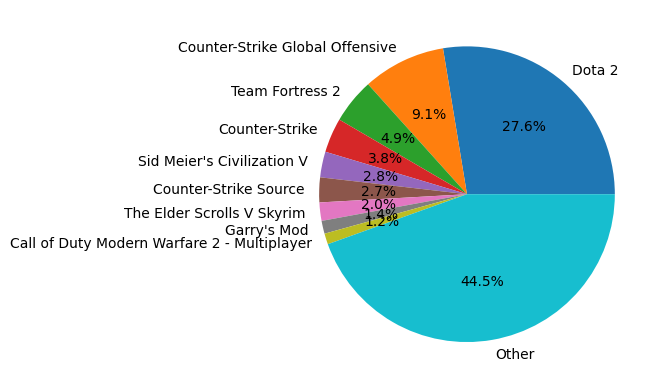

In [8]:
# Pie chart of total hours of playtime per game

df_grouped = dfPlaytime.groupby('game_name')['hours'].sum()
df_grouped = df_grouped.sort_values(ascending=False)

labels = df_grouped.index.tolist()
sizes = df_grouped.tolist()

labels = labels[0:9]
labels.append("Other")
sum_other = sum(sizes[9:])
sizes = sizes[0:9]
sizes.append(sum_other)

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')

plt.show()

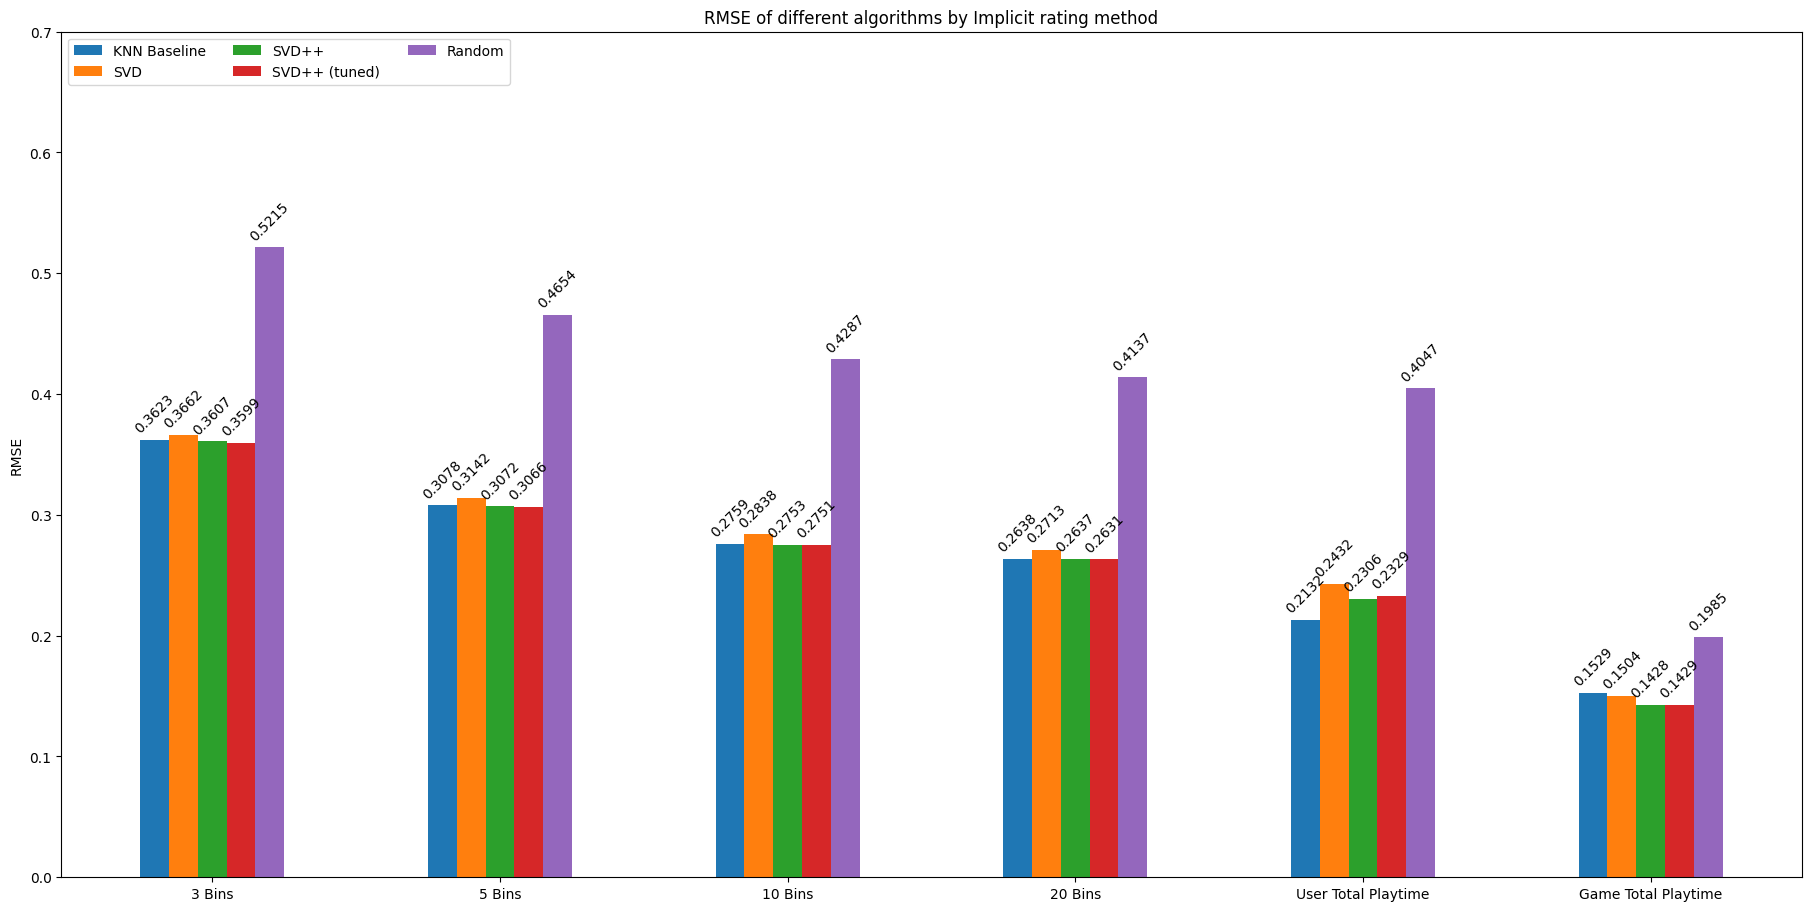

In [24]:
# Bar chart of Collaborative filtering performance
binnings = ("3 Bins", "5 Bins",  "10 Bins", "20 Bins", "User Total Playtime", "Game Total Playtime") 

start = 0
end = 6

binnings = binnings[start:end]


algorithm_rmse = {
    'KNN Baseline': list(map(lambda x: x['rmse'], results[0]))[start:end],
    'SVD': list(map(lambda x: x['rmse'], results[1]))[start:end],
    'SVD++': list(map(lambda x: x['rmse'], results[2]))[start:end],
    'SVD++ (tuned)': list(map(lambda x: x['rmse'], results[3]))[start:end],
    'Random': list(map(lambda x: x['rmse'], results[4]))[start:end],
}

x = np.arange(len(binnings))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
fig.set_size_inches(18, 9)

for attribute, measurement in algorithm_rmse.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fmt='%.4f', rotation=45)
    multiplier += 1


ax.set_ylabel('RMSE')
ax.set_title('RMSE of different algorithms by Implicit rating method')
ax.set_xticks(x + (width * (len(algorithm_rmse) - 1)) / 2, binnings)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 0.7)

plt.show()


In [25]:
# Performance Metrics as Excel File
rows = [['Preprocessing', 'Metric', 'KNNBaseline', 'SVD', 'SVD++', 'SVD++ (tuned)', 'Random']]

binningLabels = ['3 Bins', '5 Bins', '10 Bins', '20 Bins', 'User Playtime', 'Game Playtime']
metrics = ['rmse', 'mse', 'mae', 'fcp']

for i in range(6):
  for metric in metrics:
    cols = [binningLabels[i], metric.upper()]
    for algorithmIndex, algorithm in enumerate(results.keys()):
      cols.append(results[algorithm][i][metric])

    rows.append(cols)

df = pd.DataFrame(rows)
df.columns = df.iloc[0] 
df = df[1:]


writer = pd.ExcelWriter('out.xlsx', engine='xlsxwriter')
df.to_excel(index=False, excel_writer=writer)
writer.close()
files.download('out.xlsx') 


{0: [{'rmse': 0.3623314134510712, 'mse': 0.13128405317345113, 'mae': 0.2999663533353467, 'fcp': 0.6349009884957003}, {'rmse': 0.3078279626892812, 'mse': 0.09475805461343349, 'mae': 0.25299479658899005, 'fcp': 0.6290712315755994}, {'rmse': 0.27593465420043917, 'mse': 0.07613993338871594, 'mae': 0.22602149594849988, 'fcp': 0.6240110560519286}, {'rmse': 0.26379132325908683, 'mse': 0.06958586222678005, 'mae': 0.21570921342291854, 'fcp': 0.6155691474064884}, {'rmse': 0.2132025091075694, 'mse': 0.045455309889763214, 'mae': 0.10996912344750236, 'fcp': 0.38043799758157576}, {'rmse': 0.15288168518148176, 'mse': 0.023372809663929704, 'mae': 0.055116892153112024, 'fcp': 0.6540237993051461}], 1: [{'rmse': 0.3661548456525589, 'mse': 0.13406937099484925, 'mae': 0.30687087833019866, 'fcp': 0.6149142978518536}, {'rmse': 0.31421870027459975, 'mse': 0.09873339160225875, 'mae': 0.26121937063837314, 'fcp': 0.6055860610363283}, {'rmse': 0.28384947873247784, 'mse': 0.08057052657669939, 'mae': 0.235017317803

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
# Key Stats
dfNoPurchase =  dfPlaytime.loc[dfPlaytime['action'] == 'play'].drop(['action'], axis=1)

totalRows = len(dfNoPurchase)
print(f"Total rows = {totalRows}")
uniqueUsers = len(dfNoPurchase['user_id'].unique())
print(f"Unique users = {uniqueUsers}")
uniqueGames = len(dfNoPurchase['game_name'].unique())
print(f"Unique games = {uniqueGames}")
matrixSparseness = (1 - (totalRows / (uniqueUsers * uniqueGames))) * 100
print(f"User game matrix percentage = {matrixSparseness}%")
meanUserPlaytime = dfNoPurchase.groupby(['user_id'])['hours'].sum().mean()
print(f"Mean user playtime = {meanUserPlaytime}h")
medianUserPlaytime = dfNoPurchase.groupby(['user_id'])['hours'].sum().median()
print(f"Median user playtime = {medianUserPlaytime}h")

Total rows = 70489
Unique users = 11350
Unique games = 3600
User game matrix percentage = 99.82748653940284%
Mean user playtime = 303.5564581497797h
Median user playtime = 19.5h


In [27]:
# Games per user
meanUserGames = dfNoPurchase.groupby(['user_id'])['game_name'].count().mean()
print(f"Mean user games = {meanUserGames}")
medianUserGames = dfNoPurchase.groupby(['user_id'])['game_name'].count().median()
print(f"Median user games = {medianUserGames}")

dfNoPurchase.groupby(['user_id'])['game_name'].count().reset_index().groupby('game_name').count()

Mean user games = 6.210484581497798
Median user games = 1.0


,user_id
game_name,
1,6559
2,1325
3,629
4,401
5,306
...,...
297,1
298,1
299,1


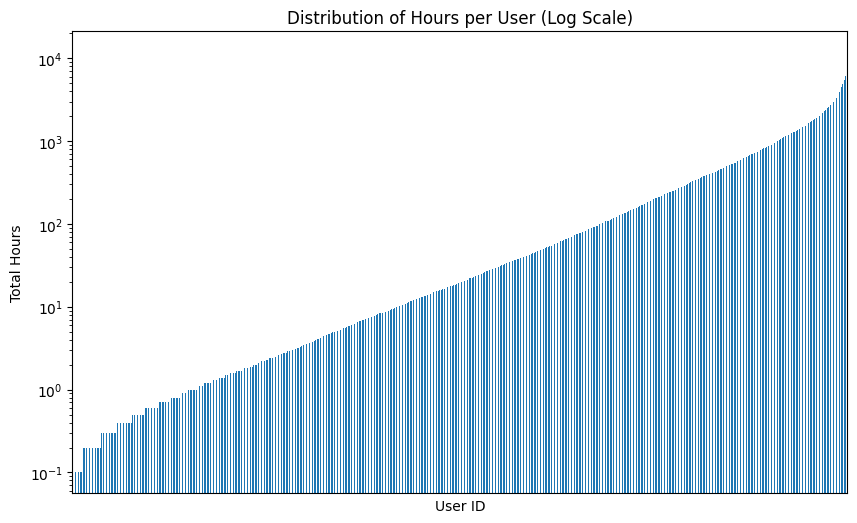

In [30]:
# Unused Chart with the distribution of hours per user (log scale)
grouped_df = dfNoPurchase.groupby('user_id')['hours'].sum()
grouped_df = grouped_df.sort_values()
ax = grouped_df.plot(kind='bar', figsize=(10, 6))
ax.set_xticks([]) 
plt.legend().remove()
plt.xlabel('User ID')
plt.ylabel('Total Hours')
plt.yscale('log')  # Set y-axis scale to logarithmic
plt.title('Distribution of Hours per User (Log Scale)')

plt.show()

In [35]:
# Stats about players per game
meanPlayersPerGame = dfNoPurchase.groupby('game_name')['user_id'].count().reset_index()['user_id'].mean()
print(f"mean players per game = {meanPlayersPerGame}")

medianPlayersPerGame = dfNoPurchase.groupby('game_name')['user_id'].count().reset_index()['user_id'].median()
print(f"median players per game = {medianPlayersPerGame}")


mean players per game = 19.580277777777777
median players per game = 4.0


# Recommendations for specific profile

In [36]:
dfCustom = pd.DataFrame(data={'user_id':
                              [
                                  'real_person_test',
                                  'real_person_test',
                                  'real_person_test',
                                  'real_person_test',
                                  'real_person_test',
                                  'real_person_test',
                                  'real_person_test',
                                  'real_person_test',
                                  'real_person_test',
                                  'real_person_test',
                                  'real_person_test',
                                  'real_person_test',
                                  'real_person_test',
                                  'real_person_test',
                                  'real_person_test',
                                  'real_person_test',
                                  'real_person_test',
                                  'real_person_test',
                                  'real_person_test',
                                  'real_person_test',
                              ],
                              "game_name": [
                                  'Space Engineers',
                                  'Tom Clancy\'s Rainbow Six Siege',
                                  'Grand Theft Auto V',
                                  'Arma 3',
                                  'Counter-Strike: Global Offensive',
                                  'Robocraft',
                                  'The Elder Scrolls V: Skyrim Special Edition',
                                  'ARK: Survival Evolved',
                                  'Factorio',
                                  'Unturned',
                                  'Just Cause 3',
                                  'Satisfactory',
                                  'ELDEN RING',
                                  'Shakes and Fidget',
                                  'The Witcher 3: Wild Hunt',
                                  'Hollow Knight',
                                  'SCP: Secret Laboratory',
                                  'Terraria',
                                  'Executive Assault',
                                  'Cyberpunk 2077',
                              ],
                              "hours": [
                                  860,
                                  856.7,
                                  608.8,
                                  522.3,
                                  426.1,
                                  350.5,
                                  325.4,
                                  216,
                                  215.8,
                                  147.5,
                                  143.2,
                                  131.9,
                                  111.5,
                                  110.7,
                                  104,
                                  96.4,
                                  76.6,
                                  73.9,
                                  68.4,
                                  60.8,
                              ]})

In [37]:
df = dfPlaytime
df = df.loc[df['action'] == 'play'].drop(['action'], axis=1)

df = pd.concat([df, dfCustom], ignore_index=True)

dfG = df.groupby('user_id')['hours'].sum()
df['hours_norm'] = df.apply(lambda row: row['hours'] / dfG.loc[row['user_id']], axis=1)
df = df.rename(columns={'hours_norm': 'Rating', 'game_name': 'Item', 'user_id': 'User'})
df = df[['User', 'Item', 'Rating']]
df = df.reset_index(drop=True)

trainset = Dataset.load_from_df(df, reader=Reader(rating_scale=(0, 1))).build_full_trainset()
algo = SVDpp(n_epochs=30, lr_all=0.005, reg_all=0.2)
algo.fit(trainset)

In [38]:
items = pd.DataFrame(dfPlaytime['game_name'].unique(), columns=['game_name'])

items['real_person_test'] = items['game_name'].apply(lambda x: algo.predict('real_person_test', x).est)
items.sort_values(['real_person_test'], ascending=False).head(10)

,game_name,real_person_test
21,Dota 2,0.569879
1400,Football Manager 2012,0.407322
1403,F1 2012,0.382621
1429,Football Manager 2009,0.377551
1897,Pro Evolution Soccer 2015,0.374633
1157,Football Manager 2013,0.373145
1683,Football Manager 2010,0.372505
3376,Professional Farmer 2014,0.368928
1820,Star Trek D-A-C,0.350322
2658,NBA 2K9,0.349618


# Archived Code

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Loading the data frame
df = pd.read_csv('./steam-200k.csv', header=None, names=["user_id", "game_name", "action", "hours", "empty_column"]).drop(['empty_column'], axis=1)

# Implementing the user-item-matrix
user_item_matrix = df.pivot_table(index='user_id', columns='game_name', values='hours', aggfunc='sum', fill_value=0)

# calculating of the item similarity based on the cosine similarity
item_similarity = cosine_similarity(user_item_matrix.T)

# Function to generate recommendations on game
def generate_item_recommendations(game_name, user_item_matrix, item_similarity, top_n=5):
    # Index of the game
    game_index = user_item_matrix.columns.get_loc(game_name)
    
    # Game similarities
    game_similarities = item_similarity[game_index]
    
    # Sorting the recommendations
    sorted_indices = np.argsort(game_similarities)[::-1]
    
    # Selection of the top games recommended
    top_similar_games = sorted_indices[:top_n]
    
    return top_similar_games

# Lets generate recommendations for a game
game_name = "I Am Alive"  
top_recommendations = generate_item_recommendations(game_name, user_item_matrix, item_similarity)
recommended_game_names = user_item_matrix.columns[top_recommendations]

print("Recommendation for game", game_name, ":")
print(recommended_game_names)

In [ ]:
import pandas as pd

dfU = pd.read_csv('./steam-200k.csv', header=None, names=["user_id", "game_name", "action", "hours", "empty_column"])
dfU.drop(['empty_column'],inplace=True,axis=1)
print(dfU.columns)

df = dfU.loc[dfU['action'] == 'purchase'].drop(['hours', 'action'], axis=1)
df = df.head(1000)
print(len(df['game_name'].unique()))
print(len(df['user_id'].unique()))

mat = pd.crosstab(index=df['user_id'], columns = df['game_name']).transpose()

user_corr = mat.corr(method='pearson')

example_user = user_corr.columns[0]
most_similar_user = user_corr[example_user][user_corr[example_user] != 1.0].idxmax()
example_similarity = user_corr[example_user][most_similar_user]
print(f"The most similar user to '{example_user}' is '{most_similar_user}'")
print(f"The similarity is: {example_similarity}")

example_item_recommendation = (mat[most_similar_user][(mat[most_similar_user] != 0) & (mat[example_user] == 0)])

if example_item_recommendation.empty:
    print("Recommendation is not possible")
else:
    print(f"We recommend game '{example_item_recommendation.index[0]}' to user '{example_user}'")
print('The user has previously played:')
print(mat.loc[mat[example_user] == 1].index.tolist())
print('The most similar user has previously played:')
print(mat.loc[mat[most_similar_user] == 1].index.tolist())